In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
from os.path import dirname
import pickle
import pandas as pd
import glob
import shapely
from shapely import geometry,ops
import numpy as np
import matplotlib.cm as cm
import pickle
import seaborn
import datetime
import pyproj
import seaborn as sns
import geopandas as gp
site_data = gp.read_file('./USGS_Streamgages-NHD_Locations.shp')
newman_df = pickle.load(open('/Users/daviddralle/Desktop/newman_df.p','rb'))
fh = glob.glob('./results/*.p')

In [90]:
# sites = []
# for f in fh: 
#     sites.append(f[10:18])

sites = newman_df.index
    
daymet_files = ['./daymet_newman/' + site + '_daymet.p' for site in sites]

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 3.58663497,  3.68663497,  3.78663497,  3.88663497,  3.98663497,
         4.08663497,  4.18663497,  4.28663497,  4.38663497,  4.48663497,
         4.58663497]),
 <a list of 10 Patch objects>)

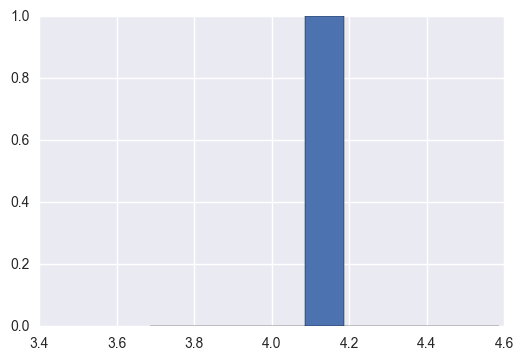

In [93]:
weather_dict = {}
seasons = ['spring', 'summer', 'fall', 'winter', 'wet']
date_condition = True
alpha_list = []
lam_list = []



for fh in daymet_files:
    try: 
        weather = pickle.load( open(fh, 'rb') )
    except: 
        print('no weather data for catchment %s'%(fh))
    
    
    for ind in range(len(seasons)):
        if seasons[ind]=='winter':
            weather_temp = weather.loc[(weather.index.month>=12)|(weather.index.month<=2)]
        elif seasons[ind]=='spring': 
            weather_temp = weather.loc[(weather.index.month>=3)&(weather.index.month<=5)]
        elif seasons[ind]=='summer':
            weather_temp = weather.loc[(weather.index.month>=6)&(weather.index.month<=8)]
        elif seasons[ind]=='fall':
            weather_temp = weather.loc[(weather.index.month>=9)&(weather.index.month<=11)]
        elif seasons[ind]=='wet':
            weather_temp = weather.loc[(weather.index.month>=11)|(weather.index.month<=4)]
        
        lam = np.sum(weather_temp.prcp>0.1)/float(len(weather_temp.prcp))
        alpha = np.mean(weather_temp.prcp.loc[weather_temp.prcp>0.1])
        alpha_list.append(alpha)
        lam_list.append(lam)
        site = fh[16:24]
        weather_dict[(site, seasons[ind])] = (alpha, lam)
        
pickle.dump(weather_dict, open('./rainfall_stats.p', 'wb'))


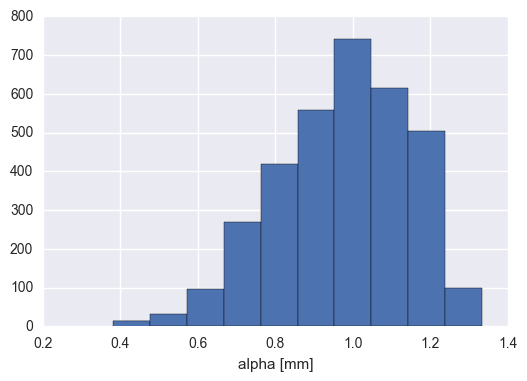

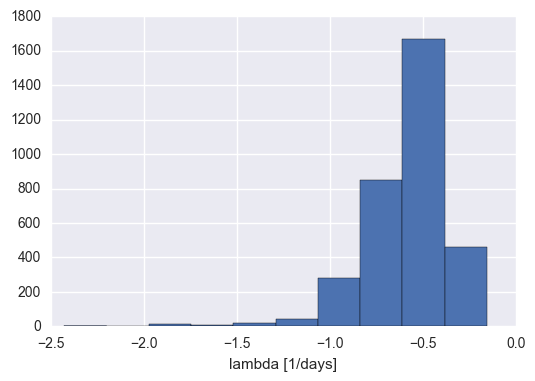

In [102]:

plt.figure()
plt.hist(np.log10(alpha_list))
plt.xlabel('alpha [mm]')
plt.figure()
plt.hist(np.log10(lam_list))
plt.xlabel('lambda [1/days]')



In [139]:
dates = []
qinc_anomaly = []
T_anomaly = []
P_anomaly = []
meantemp_color = []
theyear = []

for fh in np.random.choice(flow_files, 100):
    site = fh.split('/')[-1][:8]
    weather = pickle.load( open('./daymet_newman/'+site+'_daymet.p', 'rb') )
    weather['tmean'] = (weather.tmax + weather.tmin)/2.0
    df = pd.read_csv(fh, delim_whitespace=True, header=-1)
    df.columns = ['gagenum', 'Year', 'Month', 'Day', 'q', 'e']
    df['date'] = df[['Year', 'Month', 'Day']].apply(lambda s : datetime.datetime(*s),axis = 1)
    df = df[['q', 'date']]
    df.set_index('date', inplace=True)
    df['date'] = df.index
    df.q += 1e-12 # having flow exactly equal to zero can cause problems with logs
    df.q *= 2.447e9 #cm^3/day
    area = float(site_data['DA_SQ_MILE'].loc[site_data.SITE_NO==site])*2.58998811e10 #cm^2
    df.q = df.q/area # cm/day
    weather = weather.loc[df.index]
    weather = weather.loc[df.q>0]
    df = df.loc[df.q>0]
    
    diffq = np.diff(df.q)
    mean_qinc = np.mean(diffq[diffq>0])
#     meantemp = np.mean(weather.tmean)
    meantemp = np.mean(weather.tmean)
    meanprcp = np.mean(weather.prcp.loc[weather.prcp>0])
    P
    
#     for year in list(set(df.index.year)):
#         if len(df.loc[df.index.year==year])<365: 
#             continue
#         dftemp = df.loc[df.index.year==year]
#         weathertemp = weather.loc[weather.index.year==year]
#         diffq = np.diff(dftemp.q)
#         qinctemp = np.mean(diffq[diffq>0])
# #         qinctemp = np.percentile(diffq[diffq>0],95)
#         qinc_anomaly.append((qinctemp-mean_qinc)/mean_qinc)
# #         tmeantemp = np.mean(weathertemp.tmean)
#         tmeantemp = np.mean(weathertemp.tmax)
#         T_anomaly.append((tmeantemp-meantemp)/meantemp)
#         meanprcptemp = np.mean(weathertemp.prcp.loc[weathertemp.prcp>0])
#         P_anomaly.append((meanprcptemp-meanprcp)/meanprcp)
#         meantemp_color.append(meantemp)
#         theyear.append(year)
        
        
    

/Users/daviddralle/anaconda2/envs/py2k_model/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


(-2, 2)

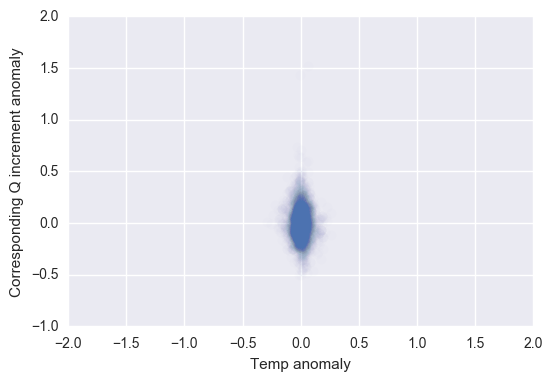

In [140]:
T_anomaly = np.array(T_anomaly)
P_anomaly = np.array(P_anomaly)
qinc_anomaly = np.array(qinc_anomaly)
idx = (np.isfinite(T_anomaly))&(np.isfinite(P_anomaly))&(T_anomaly<2)

sns.jointplot(T_anomaly[idx], P_anomaly[idx], kind='kde', xlim=[-2,2])
plt.plot(T_anomaly[idx], P_anomaly[idx],'o',alpha=0.01)

plt.xlabel('Temp anomaly')
plt.ylabel('Corresponding Q increment anomaly')
plt.xlim([-2,2])